## RQ1: How working remotly corrolates with salary?
>In this notebook, the corrolation between ***remote work options*** and ***salary*** is investigated. Stackoverflow publishes a survey every year and asks developers about different aspects of their working experience. In 2016 and 2017, developers were asked how they work remotely. I have gathered data from all three years and analyzed if there is a significant corrolation between salary and working remotely.


In [26]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from Wrangling import clean
%matplotlib inline

In [70]:
df = pd.read_csv('survey_results_public_2017.csv', encoding =  "ISO-8859-1", low_memory=False)

In [71]:
df['Country'].value_counts()

United States                 11455
India                          5197
United Kingdom                 4395
Germany                        4143
Canada                         2233
                              ...  
Pitcairn Island                   1
Cook Islands                      1
Monaco                            1
Seychelles                        1
Heard and McDonald Islands        1
Name: Country, Length: 201, dtype: int64

In [72]:
df = df[df['Country'] == 'United States']
df = df[df['HomeRemote'].notna()]
df = df[df['Salary'].notna()]

In [73]:
df['HomeRemote'].replace("All or almost all the time (I'm full-time remote)", "Full-time remote", inplace = True)
df['HomeRemote'].replace("More than half, but not all, the time", "Part-time remote", inplace = True)
df['HomeRemote'].replace("About half the time", "Part-time remote", inplace = True)
df['HomeRemote'].replace("Less than half the time, but at least one day each week", "Part-time remote", inplace = True)
df['HomeRemote'].replace("Never", "Rarely or never", inplace = True)

In [74]:
df['HomeRemote'].value_counts()

A few days each month    1577
Rarely or never           895
Part-time remote          687
Full-time remote          409
It's complicated          210
Name: HomeRemote, dtype: int64

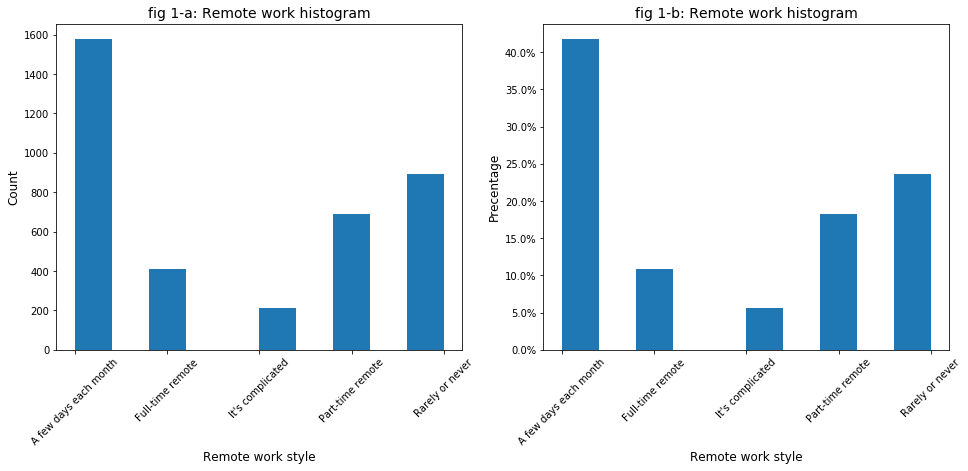

In [75]:
plt.figure(figsize= [16,6])
data = df.sort_values('HomeRemote')
base_color = sns.color_palette()[0]

plt.subplot(1,2,1)
plt.hist(data['HomeRemote'])
plt.tick_params(axis='x', rotation=45)
plt.title('fig 1-a: Remote work histogram', fontsize = 14);
plt.xlabel('Remote work style', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.subplot(1,2,2)
plt.hist(data['HomeRemote'], weights=np.ones(len(data)) / len(data))
plt.tick_params(axis='x', rotation=45)
plt.title('fig 1-b: Remote work histogram', fontsize = 14);
plt.xlabel('Remote work style', fontsize = 12)
plt.ylabel('Precentage', fontsize = 12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [76]:
# Calculate count, precentage, mean, var, std, lower 95 and upper 95
def calc_amt(df, col_name, col_calc):
    # Calculate mean for each remote category
    df_mean = df.groupby(col_name).mean()[col_calc].reset_index().rename(columns = {'Salary':'mean'})

    # Calculate var for each remote category
    df_var = df.groupby(col_name).var()[col_calc].reset_index().rename(columns = {'Salary':'var'})

    # Calculate std for each remote category
    df_std = df.groupby(col_name).std()[col_calc].reset_index().rename(columns = {'Salary':'std'})

    # Calculate count for each remote category
    df_count = df.groupby(col_name).count()[col_calc].reset_index().rename(columns = {'Salary':'count'})
    

    # Merge all
    df_all = pd.merge(df_mean, df_count, on='HomeRemote').merge(df_var, on='HomeRemote').merge(df_std, on='HomeRemote')

    # Calculate precentage
    df_all['perc'] = df_all['count'] / len(df)

    # Calculate upper and lower 95 quantiles
    df_all['lower_95'] = df_all['mean'] - 1.96*df_all['std']/np.sqrt(df_all['count'])
    df_all['upper_95'] = df_all['mean'] + 1.96*df_all['std']/np.sqrt(df_all['count'])

    return df_all

In [77]:
def color_mean(val, threshold = 4):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, green otherwise.
    """
    color = 'red' if val < threshold else 'green'
    return 'color: %s' % color

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [84]:
# check significance 
df_mean = calc_amt(df, 'HomeRemote','Salary')

df_mean.style.set_caption("Table 1: Remote working options description")
df_mean.rename(columns = {'HomeRemote':'remote'}, inplace = True)
columns = ['remote','mean','count','var','std','perc','lower_95','upper_95']
df_mean.sort_values('mean', ascending = False).reset_index()[columns].style.bar(subset=["mean"], color='lightgreen')


,remote,mean,count,var,std,perc,lower_95,upper_95
0,Full-time remote,108043.574043,409,1201806120.425138,34667.075452,0.108258,104683.787989,111403.360097
1,Part-time remote,101794.580786,687,1298321729.803595,36032.231818,0.181842,99100.138623,104489.022949
2,A few days each month,97379.102827,1577,1141737154.453100,33789.601277,0.417417,95711.382233,99046.823421
3,Rarely or never,86646.236059,895,1117518214.892333,33429.301741,0.236898,84456.096150,88836.375968
4,It's complicated,86016.390765,210,1081063169.612866,32879.525082,0.055585,81569.341303,90463.440227


In [102]:
df_mean[['mean', 'remote']]
import plotly.express as px
data_canada = df_mean[['mean', 'remote']].rename(columns = {'mean':'Salary mean'}).sort_values('Salary mean')

fig = px.bar(data_canada, x='remote', y='Salary mean')
fig.update_layout(
    autosize=False,
    width=500,
    height=400,)
fig.show()

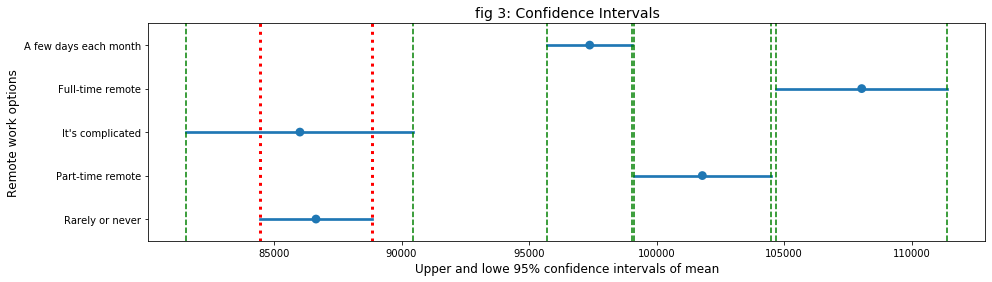

In [87]:
plt.figure(figsize= [15,4])
data1 = df_mean[['remote', 'upper_95']]
data2 = df_mean[['remote', 'lower_95']].rename(columns = {'lower_95':'upper_95'})
data = data1.append(data2)
sns.pointplot(data=data, x='upper_95', y='remote', join=False);
plt.title("fig 3: Confidence Intervals", fontsize = 14);
plt.ylabel('Remote work options', fontsize = 12)
plt.xlabel('Upper and lowe 95% confidence intervals of mean', fontsize = 12);
xcoords = data['upper_95']
for x in xcoords:
    if x > 82000 and x < 90000:
        color = 'red'
        plt.axvline(x=x, color=color, linestyle = 'dotted', linewidth =3)
    else :
        color = 'green'
        plt.axvline(x=x, color=color, linestyle = 'dashed')